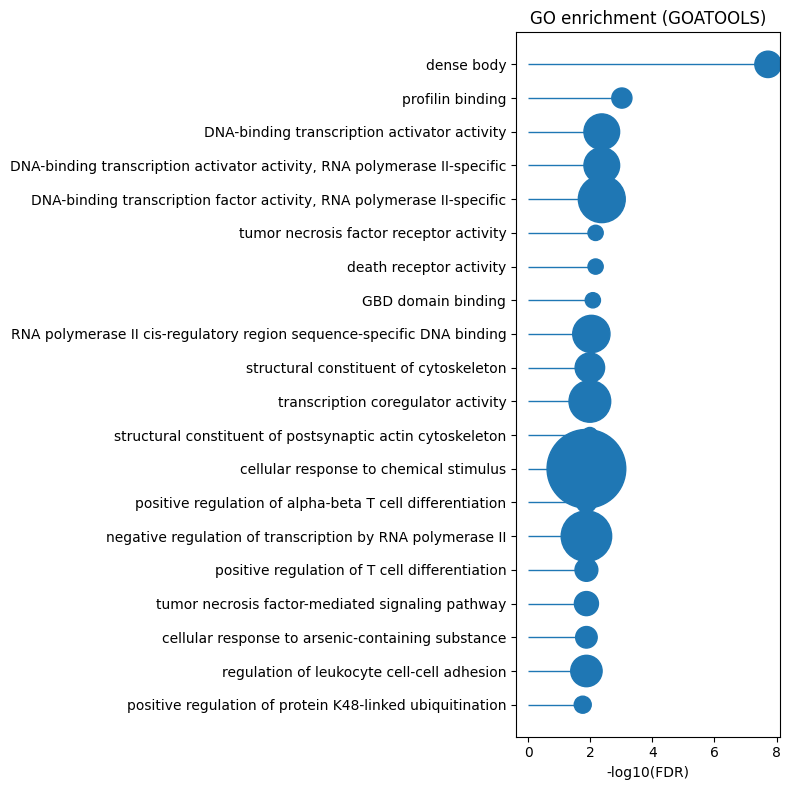

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load GOATOOLS results
# Replace with your actual filename
go_file = "sig_up_HA_GO_enrichment.tsv"

# GOATOOLS default is tab-separated
df = pd.read_csv(go_file, sep="\t")

# 2. Filter: enriched terms (enrichment == 'e') and FDR < 0.05
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()

# If nothing passes the filter, bail out gracefully
if df_filt.empty:
    raise ValueError("No GO terms pass enrichment == 'e' and p_fdr_bh < 0.05")

# Optional: take top N most significant terms
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N)

# 3. Prepare data for lollipop plot
# Use -log10(FDR) for nicer scaling on x-axis
df_plot["neg_log10_fdr"] = -np.log10(df_plot["p_fdr_bh"])

# Sort so the most significant term is at the top of the plot
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True)

y_labels = df_plot["name"]
x_vals = df_plot["neg_log10_fdr"]
sizes = df_plot["study_count"]

# Scale marker sizes for plotting (so they are visible)
size_scale = 30
marker_sizes = sizes * size_scale

# 4. Make the lollipop plot
fig, ax = plt.subplots(figsize=(8, max(4, 0.4 * len(df_plot))))

y_pos = np.arange(len(df_plot))

# Stems
ax.hlines(y=y_pos, xmin=0, xmax=x_vals, linewidth=1)

# Markers
ax.scatter(x_vals, y_pos, s=marker_sizes)

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel("-log10(FDR)")
ax.set_title("GO enrichment (GOATOOLS)")

# Tight layout so labels are readable
plt.tight_layout()

# Save and/or show
plt.savefig("go_lollipop.png", dpi=300)
plt.show()


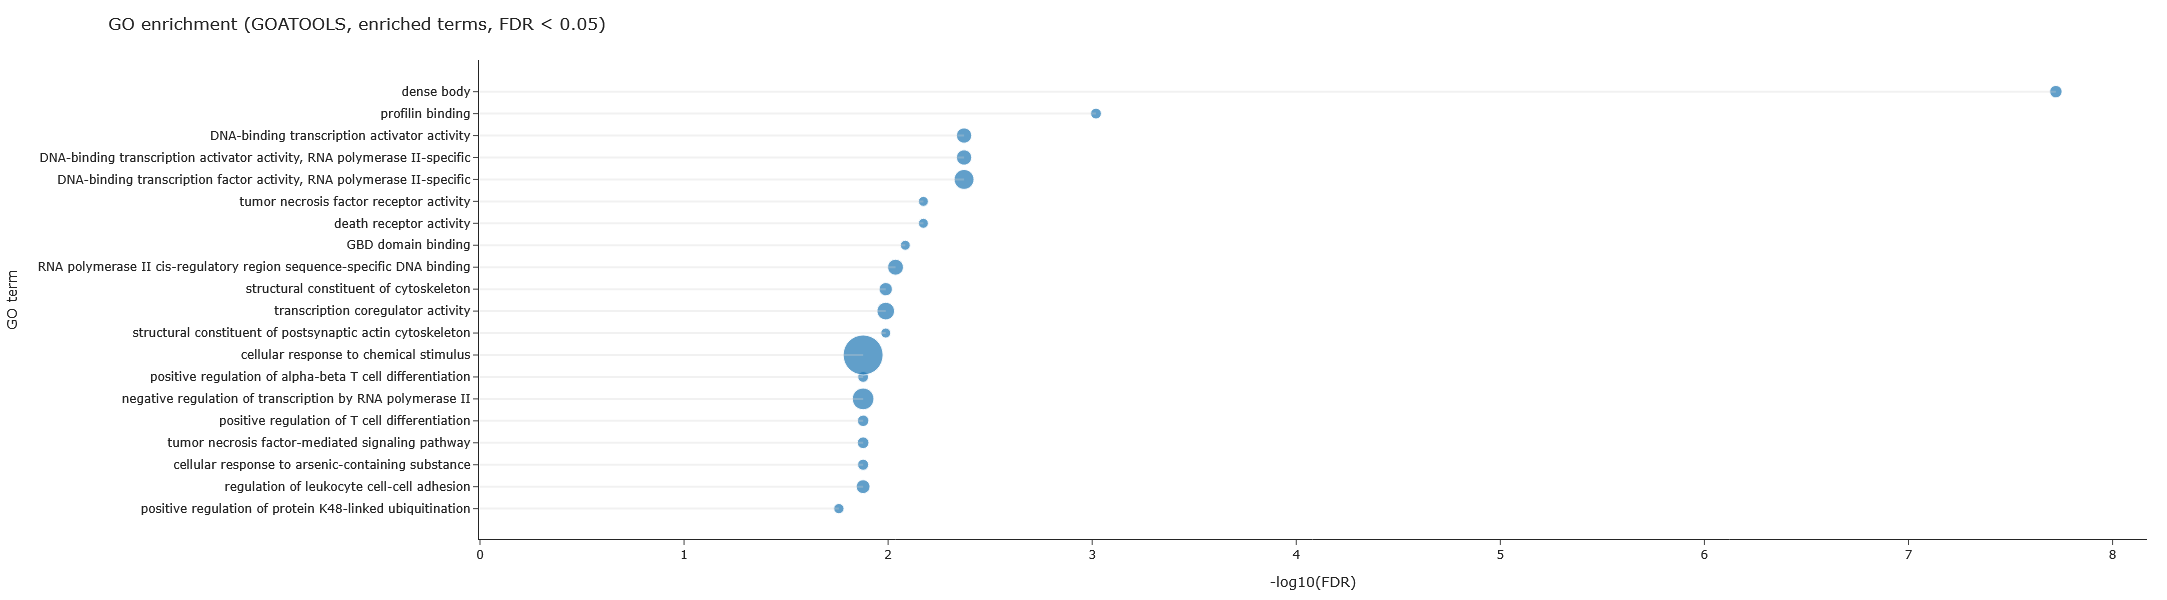

In [9]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS results
go_file = "sig_up_HA_GO_enrichment.tsv"  # change if needed
df = pd.read_csv(go_file, sep="\t")

# 2. Filter: enriched terms and FDR < 0.05
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()

if df_filt.empty:
    raise ValueError("No GO terms pass enrichment == 'e' and p_fdr_bh < 0.05")

# 3. Prepare plotting data
# Use -log10(FDR) so more significant = further right
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Take top N terms by significance
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()

# Sort so smallest neg_log10_fdr at bottom, biggest at top
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# Scale marker size from study_count
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# Build line “sticks” (lollipop stems)
shapes = []
for _, row in df_plot.iterrows():
    shapes.append(
        dict(
            type="line",
            x0=0,
            x1=row["neg_log10_fdr"],
            y0=row["ypos"],
            y1=row["ypos"],
            xref="x",
            yref="y",
            line=dict(color="lightgrey", width=2),
        )
    )

# Custom hover info
customdata = np.stack(
    [
        df_plot["name"],
        df_plot["study_count"],
        df_plot["p_fdr_bh"],
        df_plot["ratio_in_study"],
        df_plot["ratio_in_pop"],
    ],
    axis=-1,
)

fig = go.Figure()

# Lollipop heads
fig.add_trace(
    go.Scatter(
        x=df_plot["neg_log10_fdr"],
        y=df_plot["ypos"],
        mode="markers",
        marker=dict(size=sizes),
        customdata=customdata,
        hovertemplate=(
            "<b>%{customdata[0]}</b><br>"
            "-log10(FDR): %{x:.2f}<br>"
            "FDR (p_fdr_bh): %{customdata[2]:.3g}<br>"
            "Study count: %{customdata[1]}<br>"
            "Ratio in study: %{customdata[3]}<br>"
            "Ratio in population: %{customdata[4]}<extra></extra>"
        ),
    )
)

# Axes and layout
fig.update_layout(
    shapes=shapes,
    template="simple_white",
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment (GOATOOLS, enriched terms, FDR < 0.05)",
    height=max(400, 30 * len(df_plot)),
    margin=dict(l=250, r=20, t=60, b=60),
)

fig.show()


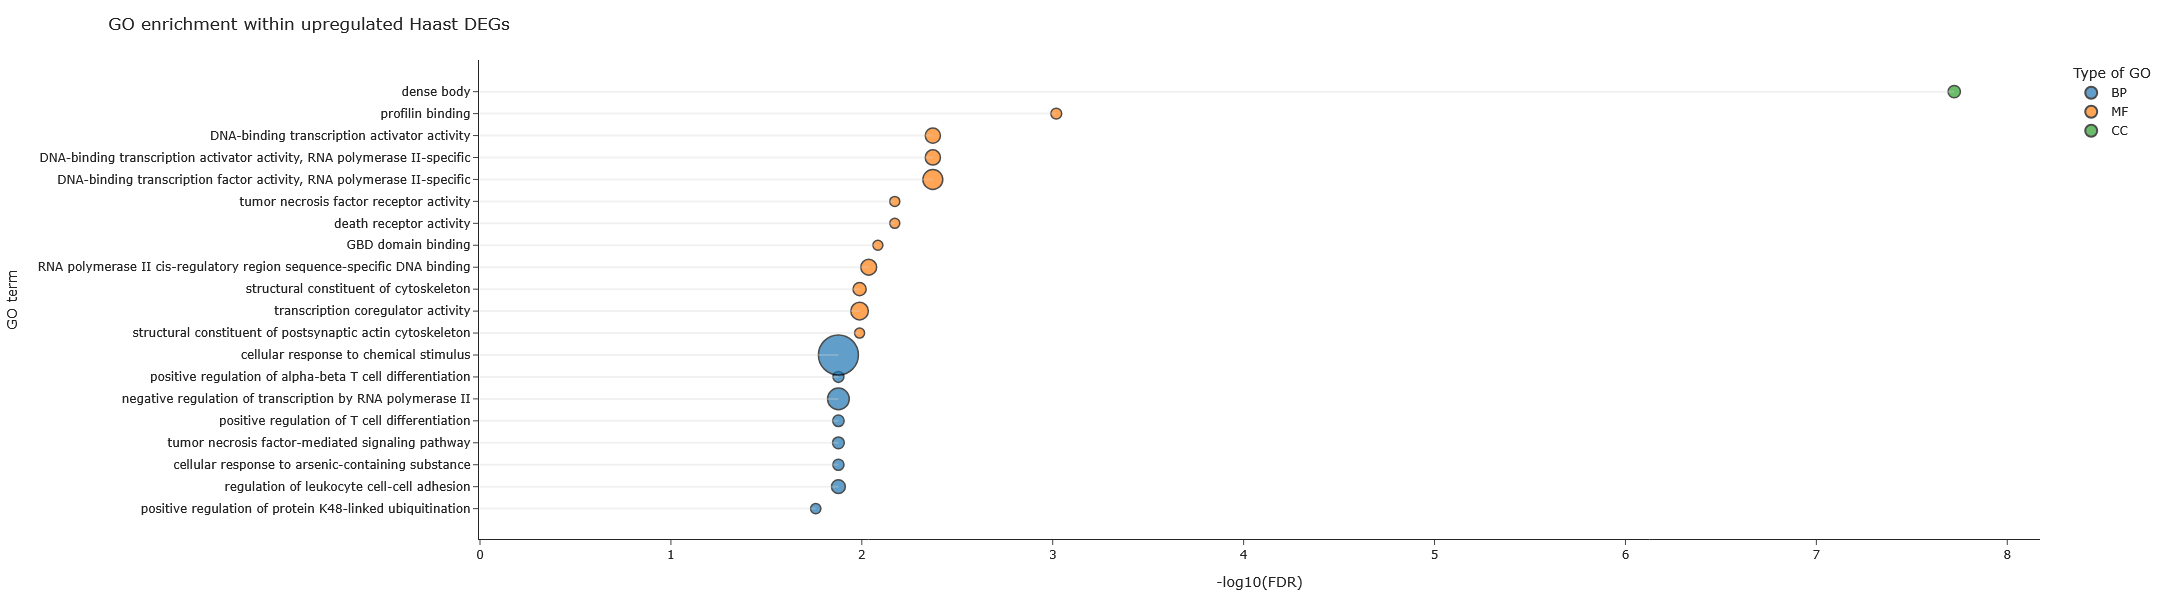

In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_up_HA_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within upregulated Haast DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


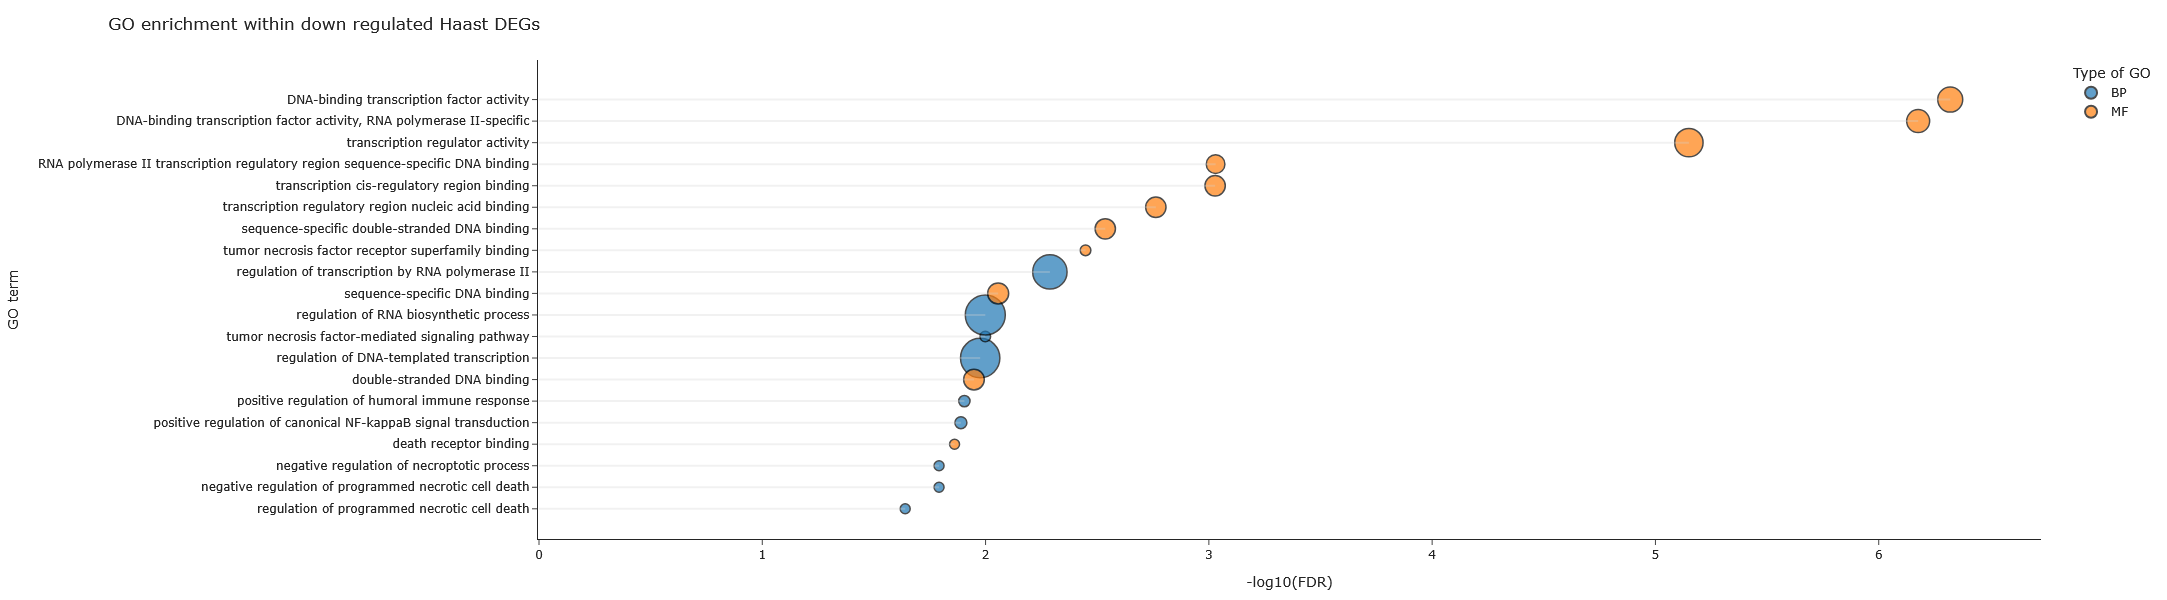

In [17]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_down_HA_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within down regulated Haast DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


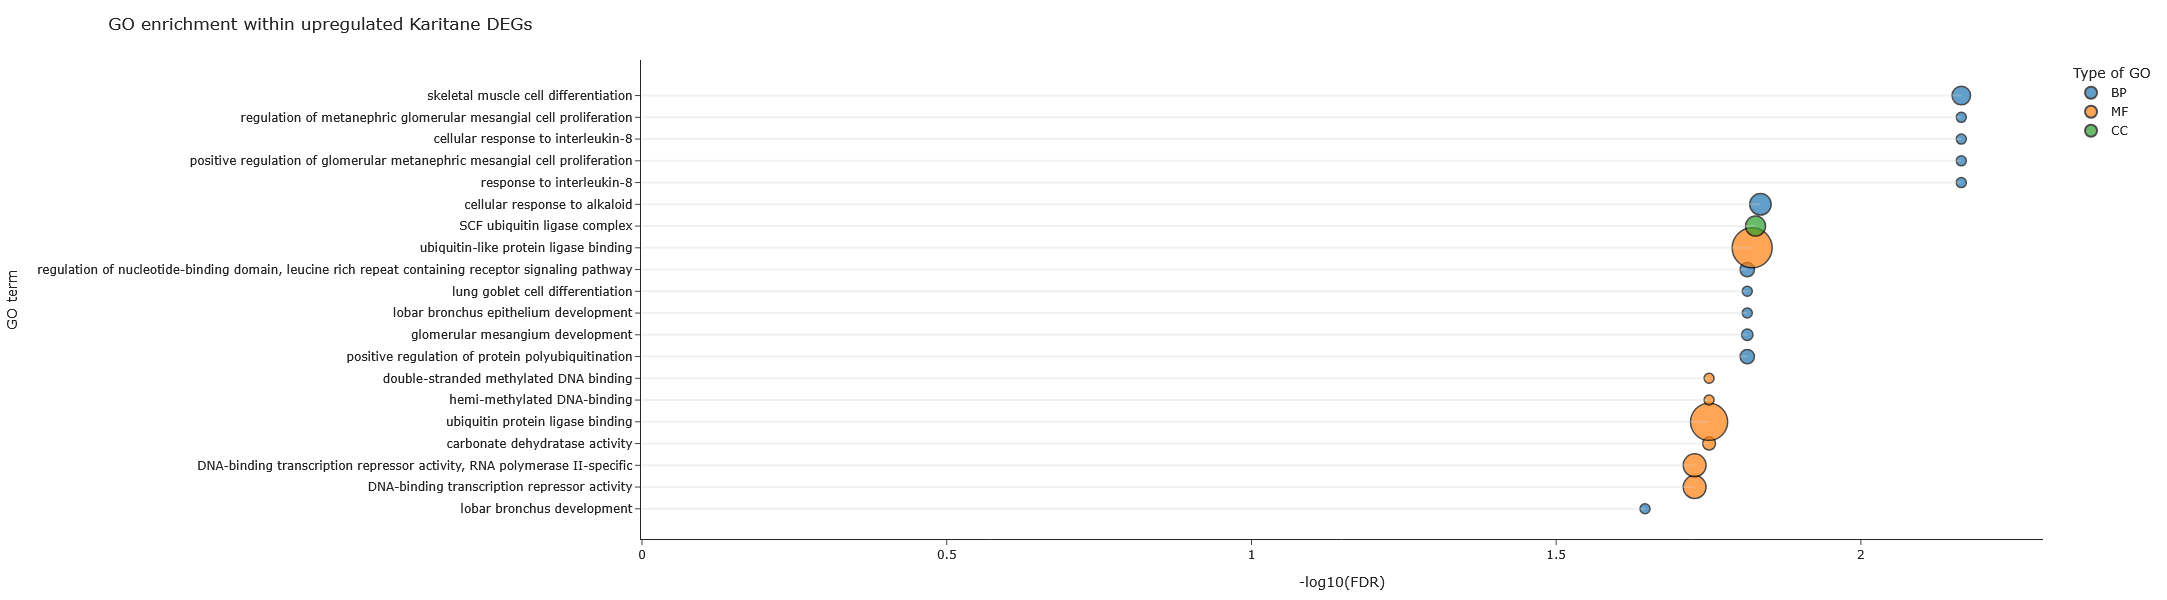

In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_up_KA_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within upregulated Karitane DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


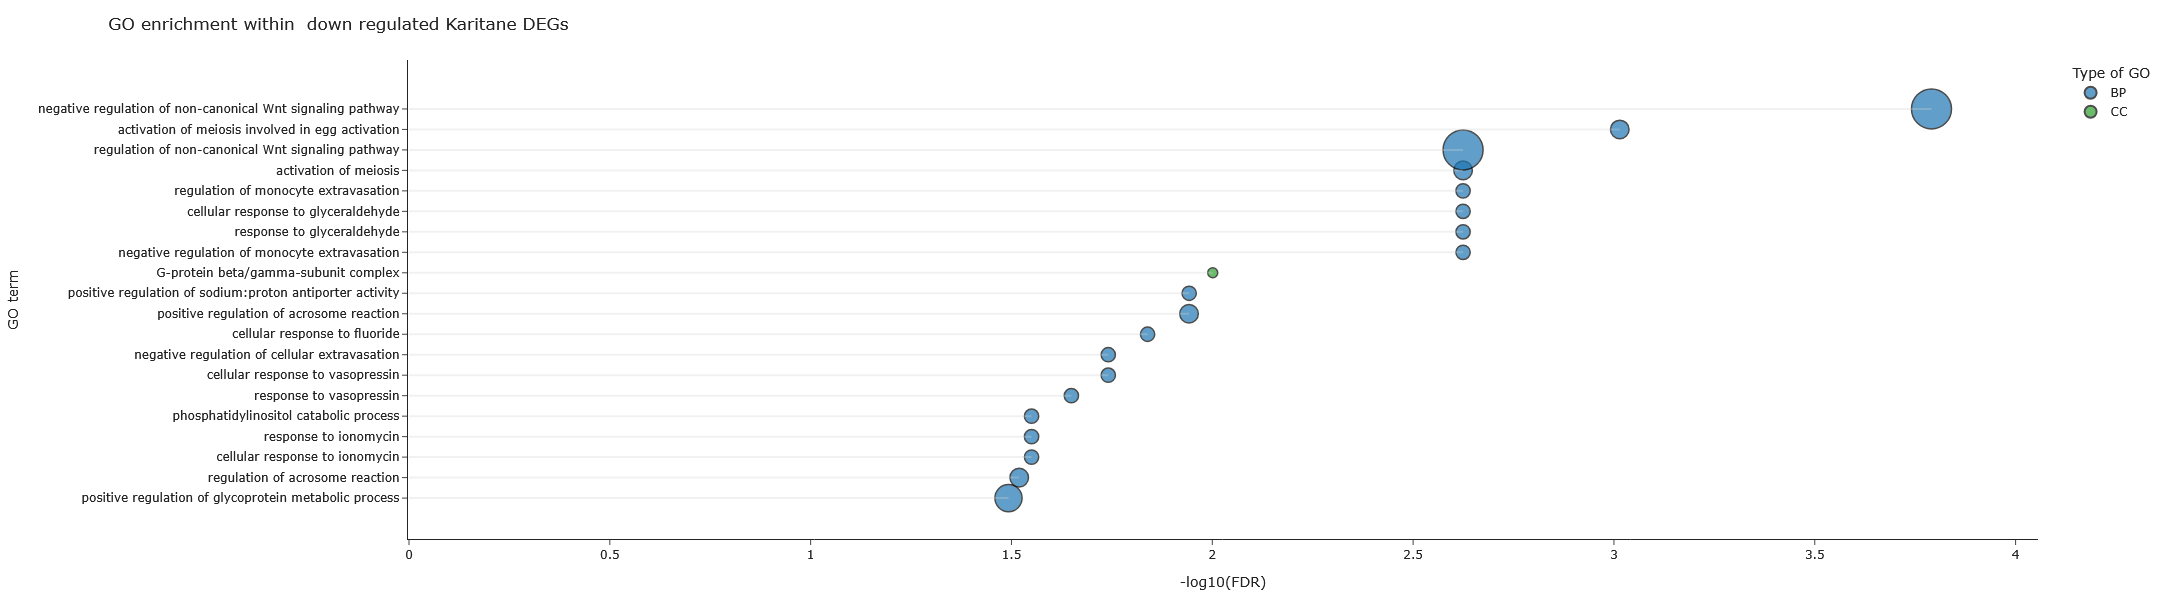

In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_down_KA_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within  down regulated Karitane DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


In [20]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_up_AK_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within  upregulated Akaroa DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


ValueError: No enriched GO terms with FDR < 0.05

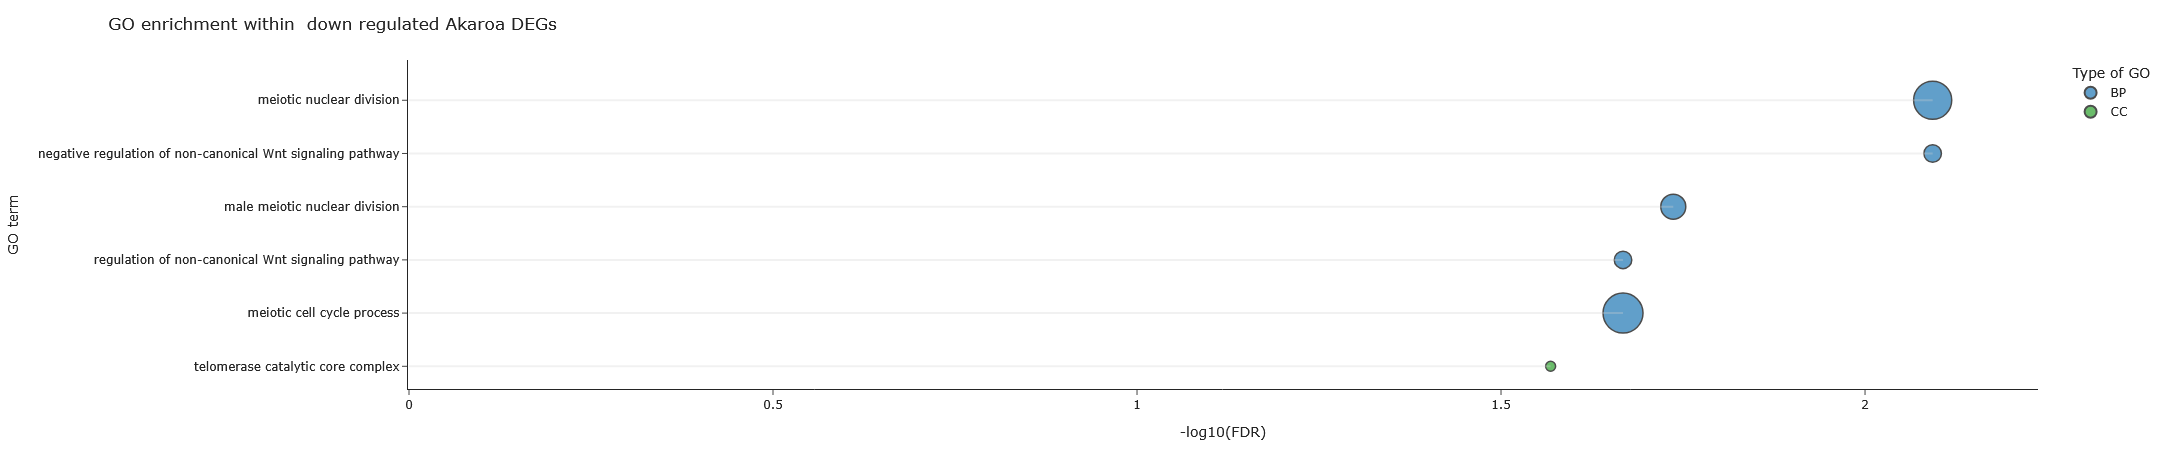

In [22]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# 1. Load GOATOOLS table
go_file = "sig_down_AK_GO_enrichment.tsv"
df = pd.read_csv(go_file, sep="\t")

# 2. Filter enriched terms + significant FDR
df_filt = df[(df["enrichment"] == "e") & (df["p_fdr_bh"] < 0.05)].copy()
if df_filt.empty:
    raise ValueError("No enriched GO terms with FDR < 0.05")

# −log10(FDR)
df_filt["neg_log10_fdr"] = -np.log10(df_filt["p_fdr_bh"])

# Colour map for NS
ns_colors = {"BP": "#1f77b4",  # blue
             "MF": "#ff7f0e",  # orange
             "CC": "#2ca02c"}  # green

# 3. Take top N most significant
N = 20
df_plot = df_filt.sort_values("p_fdr_bh").head(N).copy()
df_plot = df_plot.sort_values("neg_log10_fdr", ascending=True).reset_index(drop=True)
df_plot["ypos"] = np.arange(len(df_plot))

# 4. Size scale
size_min, size_max = 10, 40
sc = df_plot["study_count"]
sizes = size_min + (sc - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

# 5. Lollipop stems
shapes = [
    dict(
        type="line",
        x0=0, x1=row["neg_log10_fdr"],
        y0=row["ypos"], y1=row["ypos"],
        xref="x", yref="y",
        line=dict(color="lightgrey", width=2),
    )
    for _, row in df_plot.iterrows()
]

# 6. Build figure with ONE TRACE PER NAMESPACE
fig = go.Figure()

for ns in ["BP", "MF", "CC"]:
    sub = df_plot[df_plot["NS"] == ns]
    if sub.empty:
        continue

    # match size scaling
    sub_sizes = size_min + (sub["study_count"] - sc.min()) / (sc.max() - sc.min() + 1e-9) * (size_max - size_min)

    fig.add_trace(
        go.Scatter(
            x=sub["neg_log10_fdr"],
            y=sub["ypos"],
            mode="markers",
            name=ns,                        # legend entry
            marker=dict(
                size=sub_sizes,
                color=ns_colors[ns],
                line=dict(color="black", width=1.5),
            ),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Namespace: " + ns + "<br>"
                "-log10(FDR): %{x:.2f}<br>"
                "Study count: %{customdata[0]}<br>"
                "FDR: %{customdata[1]:.3g}<extra></extra>"
            ),
            text=sub["name"],
            customdata=np.stack([sub["study_count"], sub["p_fdr_bh"]], axis=-1),
        )
    )

# 7. Layout
fig.update_layout(
    template="simple_white",
    shapes=shapes,
    yaxis=dict(
        tickmode="array",
        tickvals=df_plot["ypos"],
        ticktext=df_plot["name"],
        title="GO term",
    ),
    xaxis=dict(title="-log10(FDR)"),
    title="GO enrichment within  down regulated Akaroa DEGs",
    height=max(450, 30 * len(df_plot)),
    margin=dict(l=260, r=20, t=60, b=60),
    legend=dict(
        title="Type of GO",
        itemsizing="constant",
        bgcolor="rgba(255,255,255,0.7)"
    )
)

fig.show()


In [2]:
import pandas as pd

df = pd.read_excel("AllSites_SST_2024_2025.xlsx")  # update filename
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.head()


,Date,Haast_SST,Haast_Anomaly,Haast_longtermAv_Climatology,Haast_MHW_threshold,Karitane_SST,Karitane_Anomaly,Karitane_longtermAv_Climatology,Karitane_MHW_threshold,Akaroa_SST,Akaroa_Anomaly,Akaroa_longtermAv_Climatology,Akaroa_MHW_threshold
0,2024-07-01,13.17,0.264870,12.905130,13.766774,9.91,0.106166,9.803834,10.639677,9.86,-0.201815,10.061815,10.782903
1,2024-07-02,12.28,-0.621442,12.901442,13.744355,9.77,-0.000413,9.770413,10.607097,10.02,-0.018954,10.038954,10.744355
2,2024-07-03,12.12,-0.785809,12.905809,13.721613,9.64,-0.121715,9.761715,10.575806,9.93,-0.126094,10.056094,10.707419
3,2024-07-04,11.65,-1.222955,12.872955,13.698871,8.66,-1.079405,9.739405,10.545323,9.01,-0.984622,9.994622,10.669677
4,2024-07-05,11.68,-1.195656,12.875656,13.676613,8.71,-1.026263,9.736263,10.516129,8.86,-1.093706,9.953706,10.632419


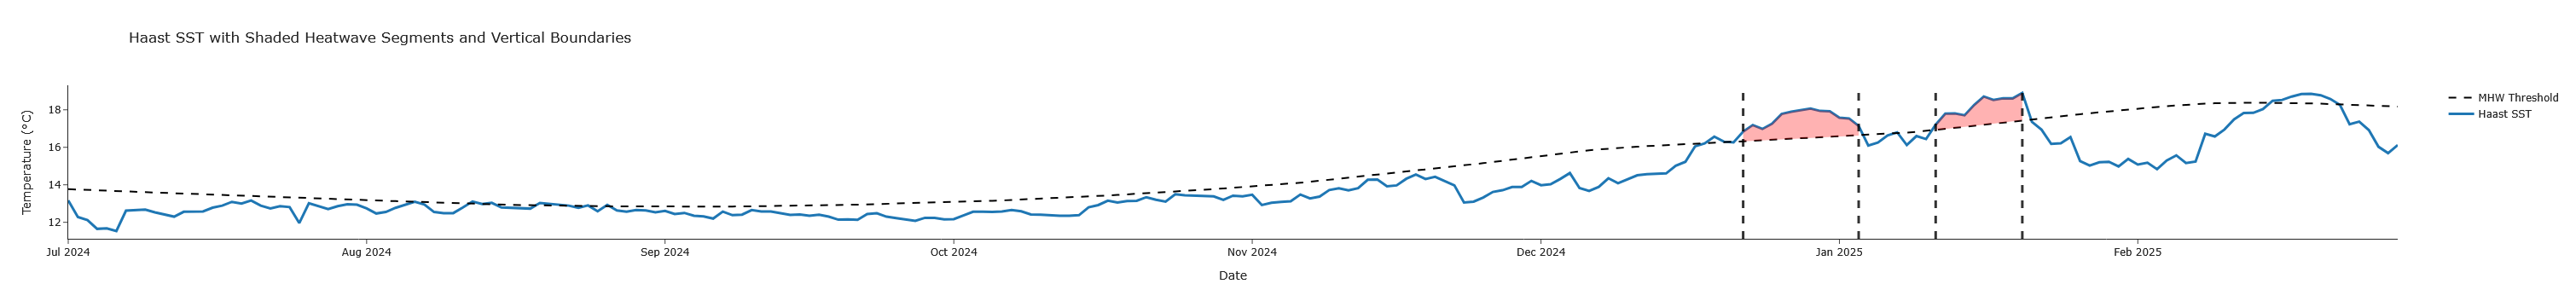

In [3]:
import plotly.graph_objects as go

x = df["Date"]
sst = df["Haast_SST"]
thr = df["Haast_MHW_threshold"]

# regions you want shaded AND vertical lines for
# regions you want shaded
regions = [
    ("2024-12-22", "2025-01-03"),
    ("2025-01-11", "2025-01-20")   # add as many as you want
]

fig = go.Figure()

# Full SST line
fig.add_trace(go.Scatter(
    x=x,
    y=sst,
    mode="lines",
    line=dict(width=3),
    name="Haast SST"
))

# Full threshold line
fig.add_trace(go.Scatter(
    x=x,
    y=thr,
    mode="lines",
    line=dict(width=2, dash="dash", color="black"),
    name="MHW Threshold"
))

# Shaded regions + vertical lines
for start_date, end_date in regions:

    mask = (x >= start_date) & (x <= end_date)

    x_seg   = x[mask]
    sst_seg = sst[mask]
    thr_seg = thr[mask]

    # baseline for fill
    fig.add_trace(go.Scatter(
        x=x_seg,
        y=thr_seg,
        mode="lines",
        line=dict(width=0),
        hoverinfo="skip",
        showlegend=False
    ))

    # roof for fill
    fig.add_trace(go.Scatter(
        x=x_seg,
        y=sst_seg,
        mode="lines",
        line=dict(width=0),
        fill="tonexty",
        fillcolor="rgba(255, 0, 0, 0.3)",
        hoverinfo="skip",
        showlegend=False
    ))

    # vertical line at start
    fig.add_vline(
        x=start_date,
        line_width=3,
        line_dash="dash",
        line_color="black",
        opacity=0.8
    )

    # vertical line at end
    fig.add_vline(
        x=end_date,
        line_width=3,
        line_dash="dash",
        line_color="black",
        opacity=0.8
    )

fig.update_layout(
    template="simple_white",
    title="Haast SST with Shaded Heatwave Segments and Vertical Boundaries",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    hovermode="x unified"
)

fig.show()


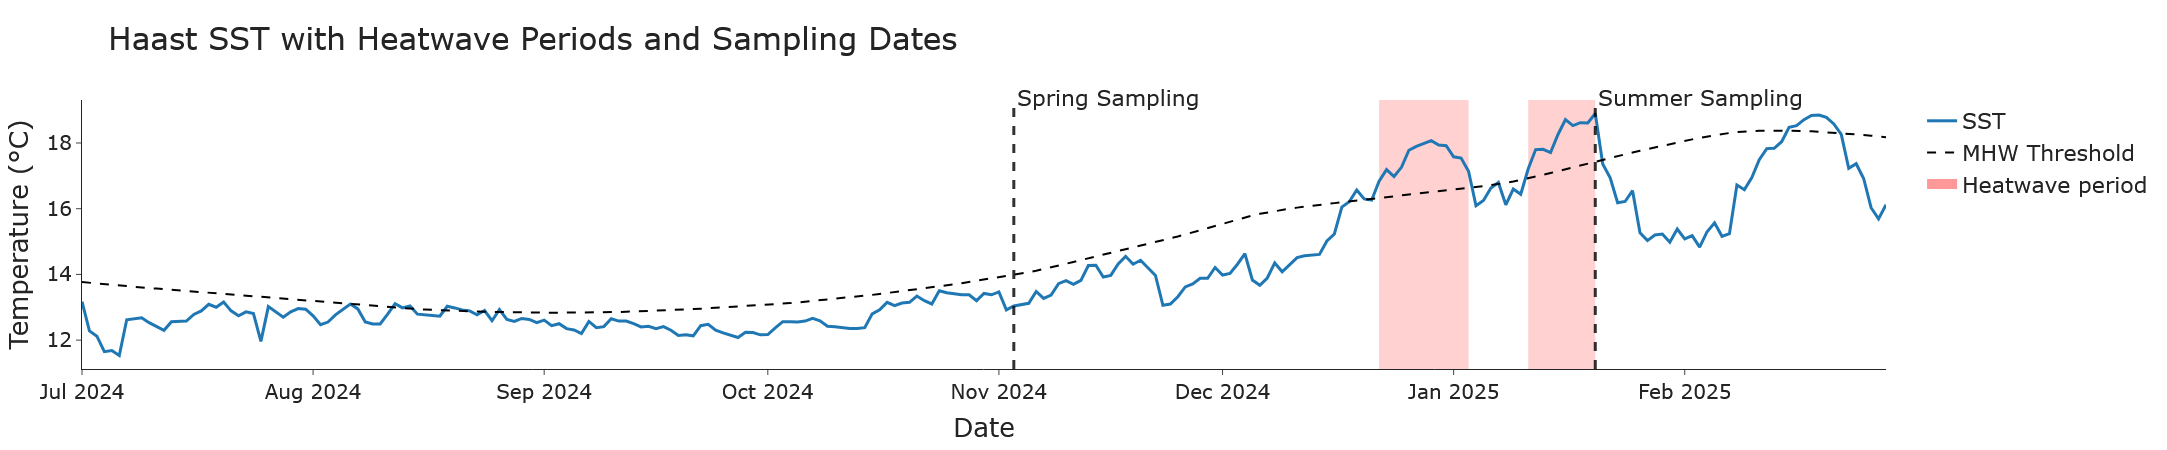

In [4]:
import plotly.graph_objects as go
import pandas as pd

x = df["Date"]
sst = df["Haast_SST"]
thr = df["Haast_MHW_threshold"]

# Heatwave region(s)
regions = [
    ("2024-12-22", "2025-01-03"),
    ("2025-01-11", "2025-01-20")
]

fig = go.Figure()

# Full SST line
fig.add_trace(go.Scatter(
    x=x,
    y=sst,
    mode="lines",
    line=dict(width=3),
    name="SST"
))

# Full threshold line
fig.add_trace(go.Scatter(
    x=x,
    y=thr,
    mode="lines",
    line=dict(width=2, dash="dash", color="black"),
    name="MHW Threshold"
))

# Vertical bands for heatwave regions
for start_date, end_date in regions:
    fig.add_vrect(
        x0=start_date,
        x1=end_date,
        fillcolor="rgba(255, 0, 0, 0.6)",   # semi-transparent red
        line_width=0,
        layer="below"                       # keep SST line above shading
    )

# Dummy trace so Heatwave appears in the legend
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode="lines",
    line=dict(color="rgba(255, 0, 0, 0.4)", width=10),
    name="Heatwave period"
))

# -----------------------------------------------------------
# Sampling dates (Haast)
# -----------------------------------------------------------

# Spring sampling: 3/11/2024
fig.add_vline(
    x="2024-11-03",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2024-11-03",
    y=0.95,
    yref="paper",
    text="Spring Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

# Summer sampling: 20/01/2025
fig.add_vline(
    x="2025-01-20",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2025-01-20",
    y=0.95,
    yref="paper",
    text="Summer Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

# Layout and fonts
fig.update_layout(
    template="simple_white",
    title="Haast SST with Heatwave Periods and Sampling Dates",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    hovermode="x unified",
    font=dict(size=22),
    xaxis_title_font=dict(size=26),
    yaxis_title_font=dict(size=26),
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    legend=dict(font=dict(size=22)), height=450
)

fig.show()


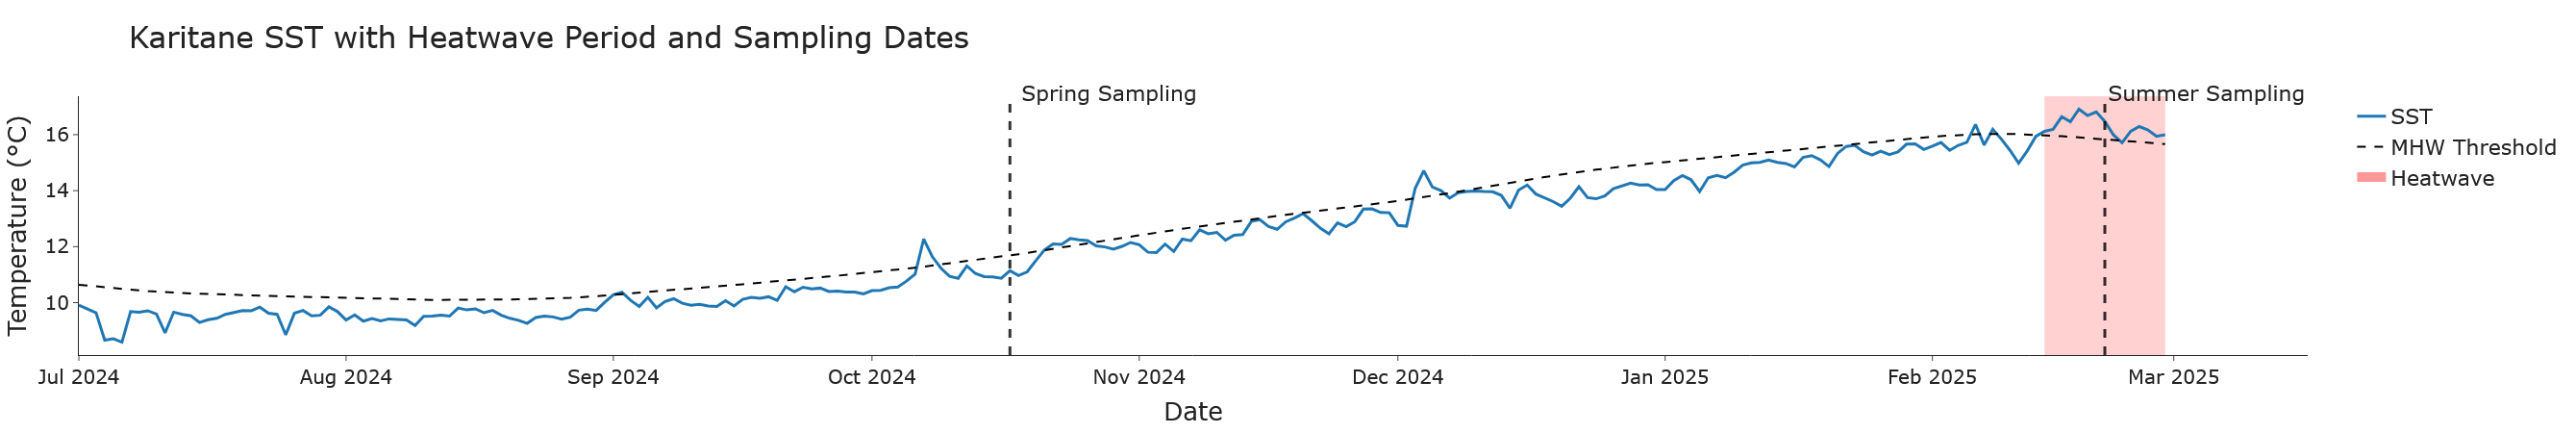

In [69]:
import plotly.graph_objects as go
import pandas as pd

x = df["Date"]
sst = df["Karitane_SST"]
thr = df["Karitane_MHW_threshold"]

# Heatwave region(s)
regions = [
    ("2025-02-14", "2025-02-28"),
]

fig = go.Figure()

# Full SST line
fig.add_trace(go.Scatter(
    x=x,
    y=sst,
    mode="lines",
    line=dict(width=3),
    name="SST"
))

# Full threshold line
fig.add_trace(go.Scatter(
    x=x,
    y=thr,
    mode="lines",
    line=dict(width=2, dash="dash", color="black"),
    name="MHW Threshold"
))

# Add vertical bands for each heatwave region
for start_date, end_date in regions:
    fig.add_vrect(
        x0=start_date,
        x1=end_date,
        fillcolor="rgba(255, 0, 0, 0.6)",  # soft red band
        line_width=0,
        layer="below"                      # keep lines on top
    )

    # Optional: label the band near the top
    mid = pd.to_datetime(start_date) + (
        pd.to_datetime(end_date) - pd.to_datetime(start_date)
    ) / 2

  # Add a dummy trace so "Heatwave" appears in the legend
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode="lines",
    line=dict(color="rgba(255, 0, 0, 0.4)", width=10),
    name="Heatwave"
))


# Sampling lines + labels (as you had)
fig.add_vline(
    x="2024-10-17",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2024-10-18",
    y=0.95,
    yref="paper",
    text="Spring Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

fig.add_vline(
    x="2025-02-21",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2025-02-21",
    y=.95,
    yref="paper",
    text="Summer Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

# Layout + larger fonts
fig.update_layout(
    template="simple_white",
    title="Karitane SST with Heatwave Period and Sampling Dates",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    hovermode="x unified",
    font=dict(size=22),
    xaxis_title_font=dict(size=26),
    yaxis_title_font=dict(size=26),
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    legend=dict(font=dict(size=22)), height=450
)

fig.show()


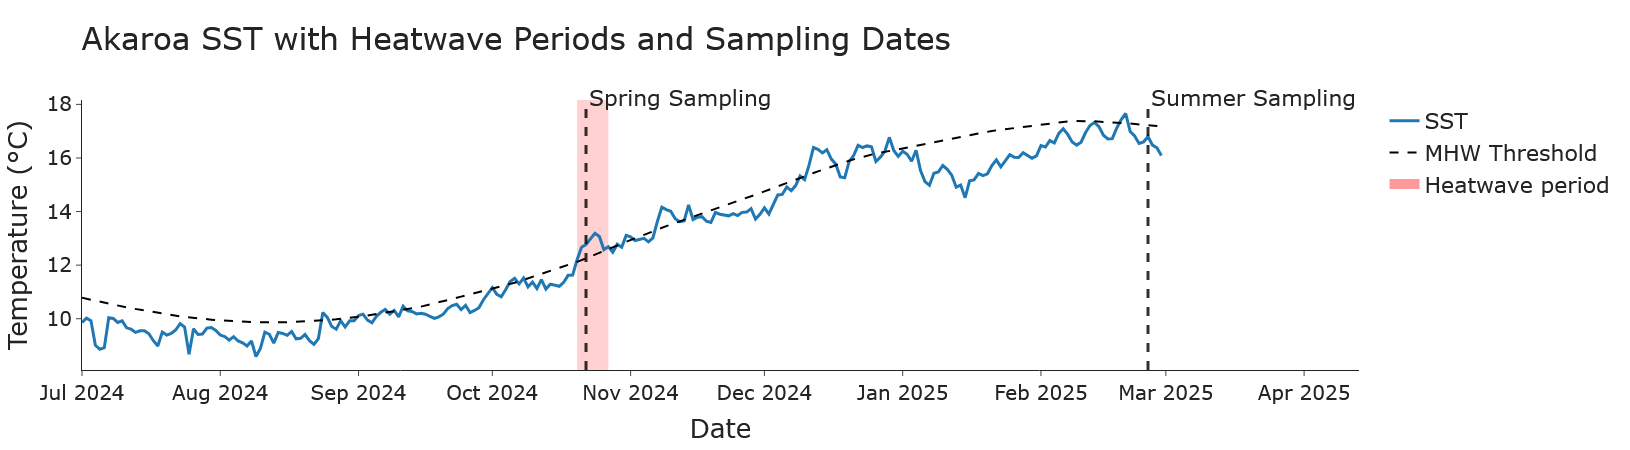

In [70]:
import plotly.graph_objects as go
import pandas as pd

x = df["Date"]
sst = df["Akaroa_SST"]
thr = df["Akaroa_MHW_threshold"]

# Heatwave region(s)
regions = [
    ("2024-10-20", "2024-10-27")
]

fig = go.Figure()

# Full SST line
fig.add_trace(go.Scatter(
    x=x,
    y=sst,
    mode="lines",
    line=dict(width=3),
    name="SST"
))

# Full threshold line
fig.add_trace(go.Scatter(
    x=x,
    y=thr,
    mode="lines",
    line=dict(width=2, dash="dash", color="black"),
    name="MHW Threshold"
))

# Vertical bands for heatwave regions
for start_date, end_date in regions:
    fig.add_vrect(
        x0=start_date,
        x1=end_date,
        fillcolor="rgba(255, 0, 0, 0.6)",   # semi-transparent red
        line_width=0,
        layer="below"                       # keep SST line above shading
    )

# Dummy trace so Heatwave appears in the legend
fig.add_trace(go.Scatter(
    x=[None],
    y=[None],
    mode="lines",
    line=dict(color="rgba(255, 0, 0, 0.4)", width=10),
    name="Heatwave period"
))

# -----------------------------------------------------------
# Sampling dates (Haast)
# -----------------------------------------------------------

# Spring sampling: 3/11/2024
fig.add_vline(
    x="2024-10-22",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2024-10-22",
    y=0.95,
    yref="paper",
    text="Spring Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

# Summer sampling: 20/01/2025
fig.add_vline(
    x="2025-02-25",
    line_width=3,
    line_dash="dash",
    line_color="black",
    opacity=0.8
)
fig.add_annotation(
    x="2025-02-25",
    y=0.95,
    yref="paper",
    text="Summer Sampling",
    showarrow=False,
    xanchor="left",
    yanchor="bottom",
    font=dict(size=22)
)

# Layout and fonts
fig.update_layout(
    template="simple_white",
    title="Akaroa SST with Heatwave Periods and Sampling Dates",
    xaxis_title="Date",
    yaxis_title="Temperature (°C)",
    hovermode="x unified",
    font=dict(size=22),
    xaxis_title_font=dict(size=26),
    yaxis_title_font=dict(size=26),
    xaxis=dict(tickfont=dict(size=20)),
    yaxis=dict(tickfont=dict(size=20)),
    legend=dict(font=dict(size=22)), height=450
)

fig.show()
